In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

✓ Training data loaded: 640 rows, 10 columns
✓ Test data loaded: 200 rows, 10 columns

Column names: ['cape', 'cin', 'dewpoint_2m', 'temp_2m', 'tcwv', 'surface_pressure', 'shear_0_1km', 'shear_0_3km', 'ef_class', 'ef_binary']

--------------------------------------------------------------------------------
TRAINING DATA INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cape              640 non-null    float64
 1   cin               295 non-null    float64
 2   dewpoint_2m       640 non-null    float64
 3   temp_2m           640 non-null    float64
 4   tcwv              640 non-null    float64
 5   surface_pressure  640 non-null    float64
 6   shear_0_1km       640 non-null    float64
 7   shear_0_3km       640 non-null    float64
 8   ef_class   

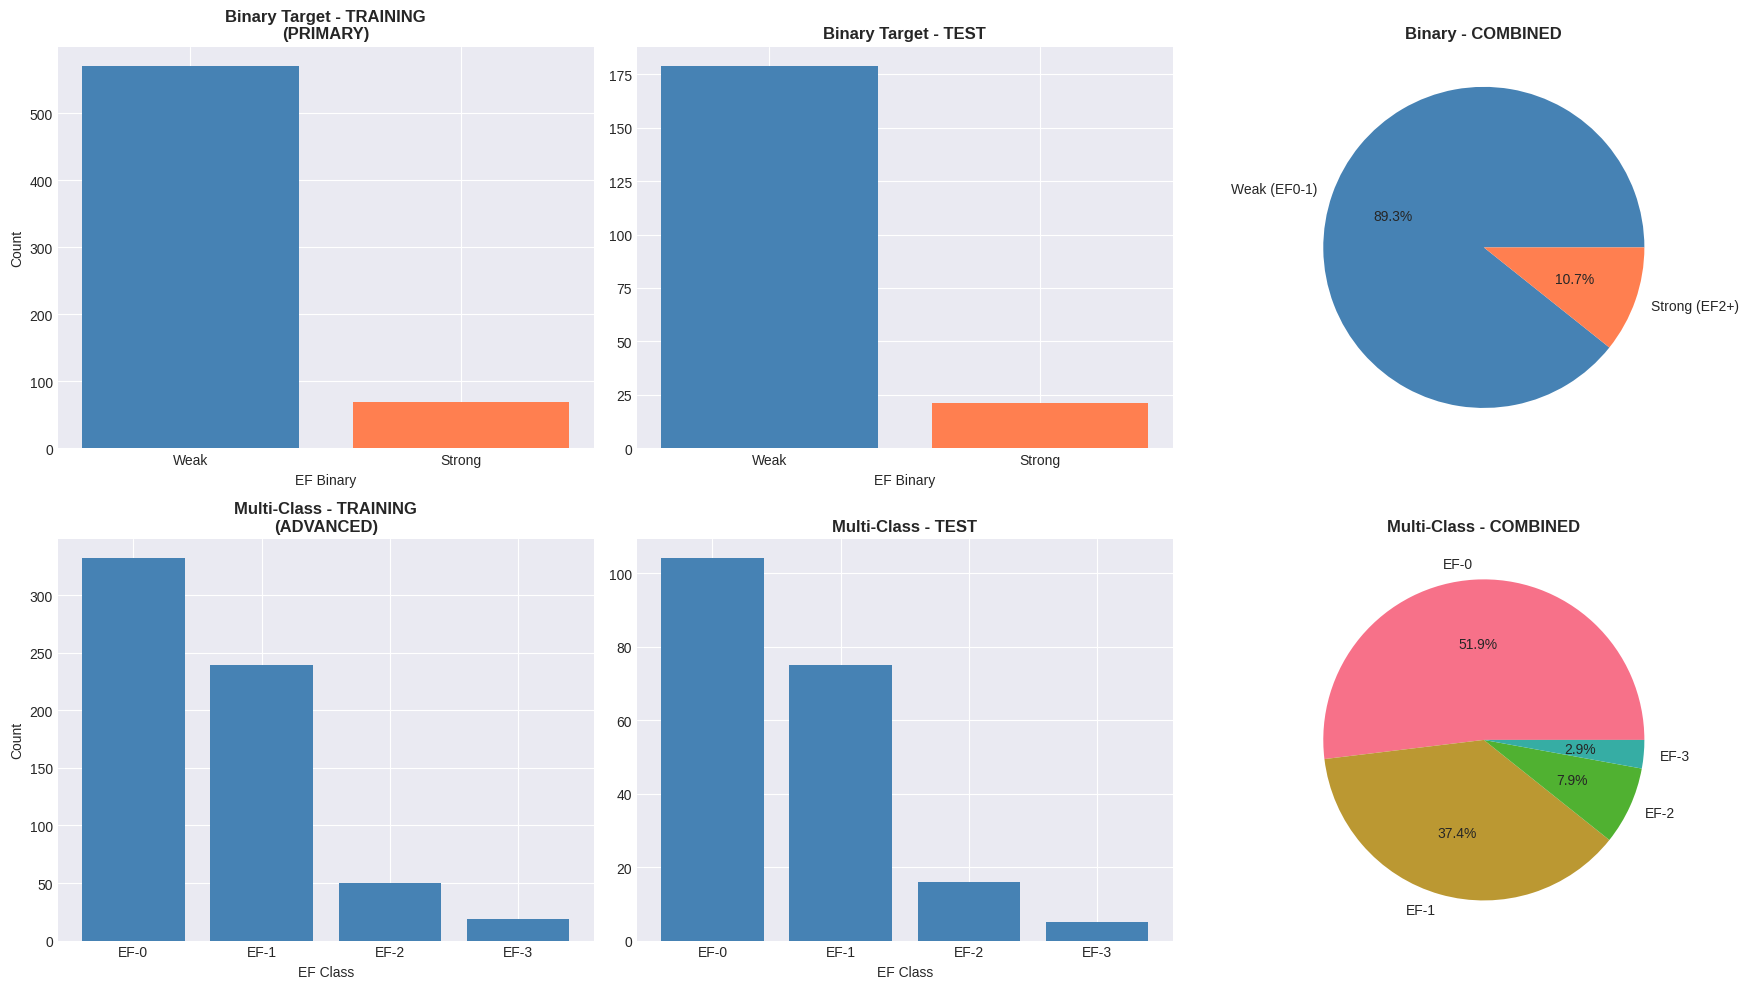

In [ ]:
# ============================================================================
# STEP 2: LOAD AND EXPLORE DATA
# ============================================================================

# Data paths
TRAIN_FILE = '2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")


# Load test data
df_test = pd.read_excel(TEST_FILE)
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

# Basic information
print(f"\nColumn names: {df_train.columns.tolist()}")

print("\n" + "-" * 80)
print("TRAINING DATA INFO:")
print("-" * 80)
print(df_train.info())

print("\n" + "-" * 80)
print("STATISTICAL SUMMARY (TRAINING):")
print("-" * 80)
print(df_train.describe())

print("\n" + "-" * 80)
print("MISSING VALUES:")
print("-" * 80)
missing_train = df_train.isnull().sum()
missing_train = missing_train[missing_train > 0]
if len(missing_train) > 0:
    print("Training set:")
    print(missing_train)
else:
    print("Training set: No missing values")

missing_test = df_test.isnull().sum()
missing_test = missing_test[missing_test > 0]
if len(missing_test) > 0:
    print("\nTest set:")
    print(missing_test)
else:
    print("\nTest set: No missing values")

# Target distributions
print("\n" + "-" * 80)
print("TARGET DISTRIBUTIONS:")
print("-" * 80)
print("\nBINARY (PRIMARY CHALLENGE) - Training:")
print(df_train['ef_binary'].value_counts().sort_index())
print(f"Imbalance ratio: {df_train['ef_binary'].value_counts()[0] / df_train['ef_binary'].value_counts()[1]:.2f}:1")

print("\nBINARY - Test:")
print(df_test['ef_binary'].value_counts().sort_index())

print("\nMULTI-CLASS (ADVANCED) - Training:")
print(df_train['ef_class'].value_counts().sort_index())

print("\nMULTI-CLASS - Test:")
print(df_test['ef_class'].value_counts().sort_index())

# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Binary - Training
axes[0, 0].bar([0, 1], df_train['ef_binary'].value_counts().sort_index(),
               color=['steelblue', 'coral'])
axes[0, 0].set_title('Binary Target - TRAINING\n(PRIMARY)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('EF Binary')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Weak', 'Strong'])

# Binary - Test
axes[0, 1].bar([0, 1], df_test['ef_binary'].value_counts().sort_index(),
               color=['steelblue', 'coral'])
axes[0, 1].set_title('Binary Target - TEST', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('EF Binary')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Weak', 'Strong'])

# Binary - Combined pie
combined_binary = pd.concat([df_train['ef_binary'], df_test['ef_binary']])
axes[0, 2].pie(combined_binary.value_counts().sort_index(),
               labels=['Weak (EF0-1)', 'Strong (EF2+)'],
               autopct='%1.1f%%', colors=['steelblue', 'coral'])
axes[0, 2].set_title('Binary - COMBINED', fontsize=12, fontweight='bold')

# Multi-class - Training
axes[1, 0].bar(range(4), df_train['ef_class'].value_counts().sort_index(), color='steelblue')
axes[1, 0].set_title('Multi-Class - TRAINING\n(ADVANCED)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('EF Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(range(4))
axes[1, 0].set_xticklabels([f'EF-{i}' for i in range(4)])

# Multi-class - Test
axes[1, 1].bar(range(4), df_test['ef_class'].value_counts().sort_index(), color='steelblue')
axes[1, 1].set_title('Multi-Class - TEST', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('EF Class')
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels([f'EF-{i}' for i in range(4)])

# Multi-class - Combined pie
combined_class = pd.concat([df_train['ef_class'], df_test['ef_class']])
axes[1, 2].pie(combined_class.value_counts().sort_index(),
               labels=[f'EF-{i}' for i in range(4)], autopct='%1.1f%%')
axes[1, 2].set_title('Multi-Class - COMBINED', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# STEP 3: DATA PREPROCESSING
# ============================================================================

# Separate features and targets
X_train = df_train.drop(['ef_class', 'ef_binary'], axis=1, errors='ignore')
X_test = df_test.drop(['ef_class', 'ef_binary'], axis=1, errors='ignore')

y_train_binary = df_train['ef_binary']
y_test_binary = df_test['ef_binary']

y_train_class = df_train['ef_class']
y_test_class = df_test['ef_class']

# Handle missing values - TO CHECK LATER (drop or get median for the subclass)
imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Normalize features

# use for -1 to 1
#scaler = StandardScaler()

#use for 0 to 1
scaler= MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [6]:
print("\n" + "=" * 80)
print("STEP 5A: EXPORTING NORMALIZED DATASET")
print("=" * 80)

# Define output paths
X_TRAIN_SCALED_FILE = '/content/X_train_scaled.csv'
X_TEST_SCALED_FILE = '/content/X_test_scaled.csv'

# Export to CSV
try:
    X_train_scaled.to_csv(X_TRAIN_SCALED_FILE, index=False)
    print(f"✓ Normalized training data exported to: {X_TRAIN_SCALED_FILE}")
except Exception as e:
    print(f"❌ Error exporting training data: {e}")

try:
    X_test_scaled.to_csv(X_TEST_SCALED_FILE, index=False)
    print(f"✓ Normalized test data exported to: {X_TEST_SCALED_FILE}")
except Exception as e:
    print(f"❌ Error exporting test data: {e}")


STEP 5A: EXPORTING NORMALIZED DATASET
❌ Error exporting training data: Cannot save file into a non-existent directory: '/content'
❌ Error exporting test data: Cannot save file into a non-existent directory: '/content'


In [9]:
# ============================================================================
# STEP 4: CORRELATION MATRIX
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: CORRELATION ANALYSIS")
print("=" * 80)

correlation_matrix = X_train_scaled.corr()

# plt.figure(figsize=(12, 10))
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
#             square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
# plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
# plt.tight_layout()
# plt.show()
correlation_matrix.to_csv("correlation_matrix.csv")



STEP 4: CORRELATION ANALYSIS



STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)

Variance Explained by Components:
PC1: 36.79% (Cumulative: 36.79%)
PC2: 25.77% (Cumulative: 62.57%)
PC3: 12.38% (Cumulative: 74.95%)
PC4: 10.32% (Cumulative: 85.27%)
PC5: 5.32% (Cumulative: 90.59%)
PC6: 4.06% (Cumulative: 94.65%)
PC7: 3.43% (Cumulative: 98.08%)
PC8: 1.92% (Cumulative: 100.00%)


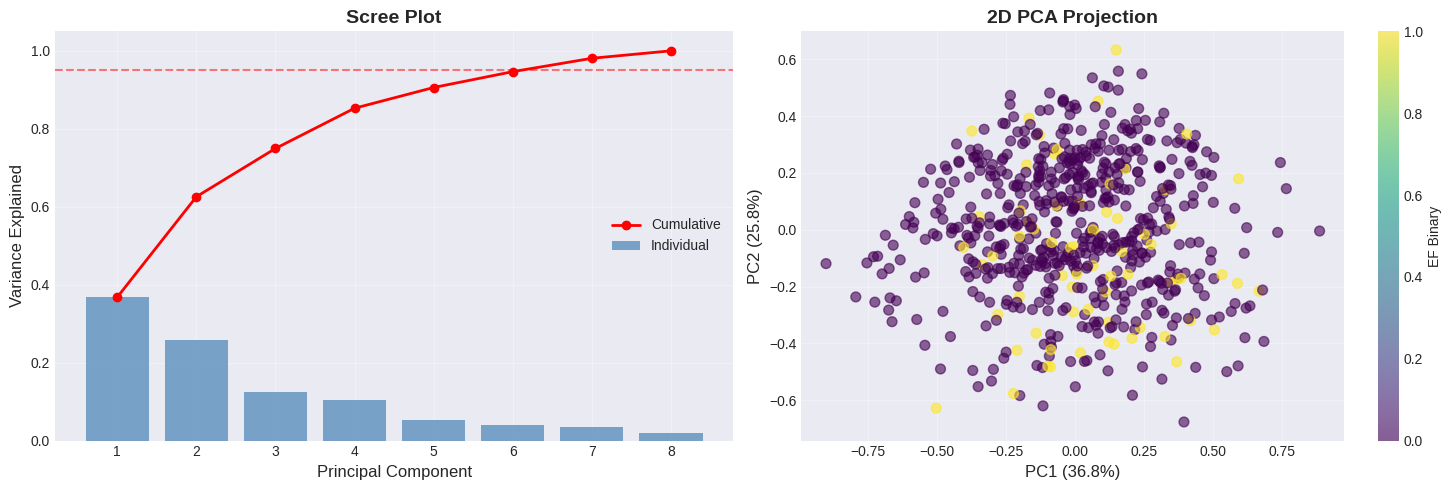

In [32]:
# ============================================================================
# STEP 5: PCA ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 80)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print("\nVariance Explained by Components:")
for i, (var, cum_var) in enumerate(zip(variance_explained, cumulative_variance)):
    print(f"PC{i+1}: {var*100:.2f}% (Cumulative: {cum_var*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].bar(range(1, len(variance_explained)+1), variance_explained, alpha=0.7,
            color='steelblue', label='Individual')
axes[0].plot(range(1, len(variance_explained)+1), cumulative_variance,
             'ro-', linewidth=2, label='Cumulative')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].axhline(y=0.95, color='red', linestyle='--', alpha=0.5)

# 2D PCA
scatter = axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                         c=y_train_binary, cmap='viridis', alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('2D PCA Projection', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='EF Binary')

plt.tight_layout()
plt.show()


STEP 6A: BINARY CLASSIFICATION - PRIMARY CHALLENGE

Applying SMOTE for binary classification...
✓ Training samples: 640 → 1142
  Class 0: 571
  Class 1: 571

--------------------------------------------------------------------------------
TRAINING BINARY CLASSIFICATION MODELS:
--------------------------------------------------------------------------------

Training: Logistic Regression
  CV ROC AUC: 0.6879 (±0.0139)
  Test ROC AUC: 0.6621 | Accuracy: 0.5900

Training: Random Forest
  CV ROC AUC: 0.9068 (±0.0144)
  Test ROC AUC: 0.6824 | Accuracy: 0.7400

Training: Gradient Boosting
  CV ROC AUC: 0.9481 (±0.0076)
  Test ROC AUC: 0.6539 | Accuracy: 0.7800

Training: XGBoost
  CV ROC AUC: 0.9450 (±0.0100)
  Test ROC AUC: 0.6675 | Accuracy: 0.7700

STEP 7A: BINARY CLASSIFICATION EVALUATION

MODEL COMPARISON:
                      cv_mean test_roc_auc test_accuracy
Logistic Regression  0.687911     0.662144          0.59
Random Forest        0.906828     0.682362          0.74
Gradient Bo

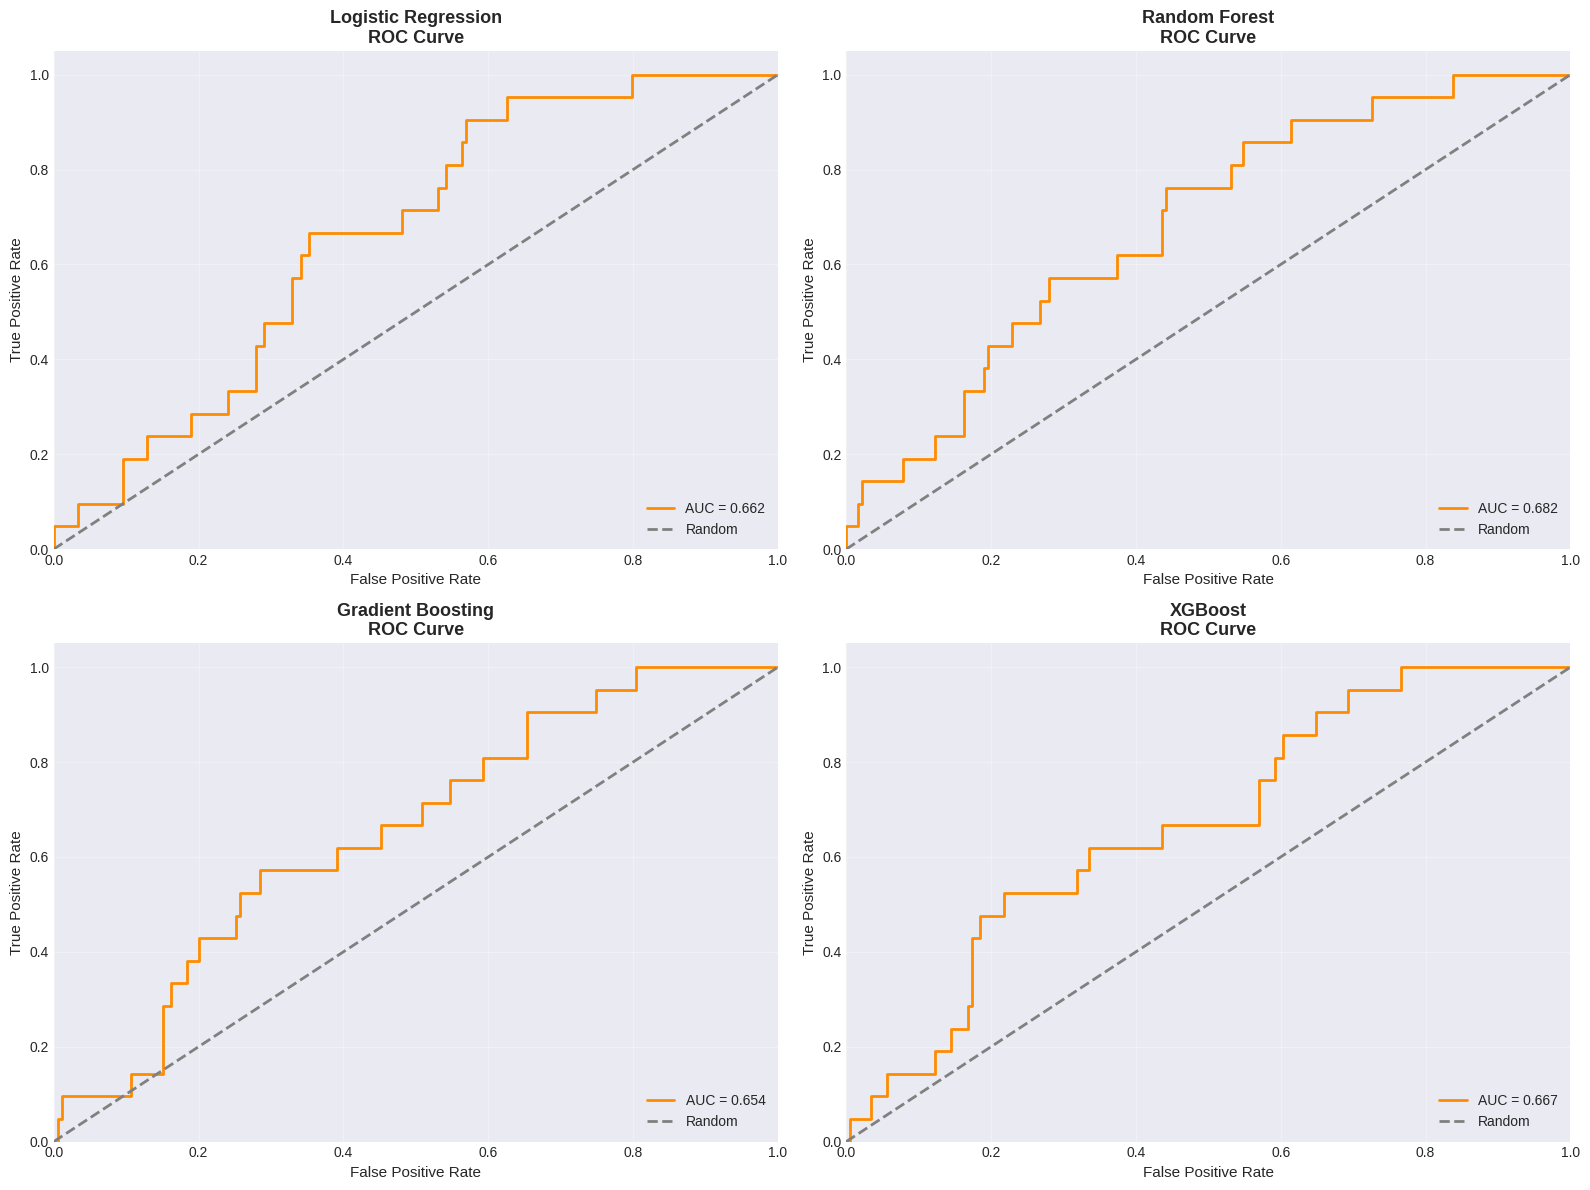

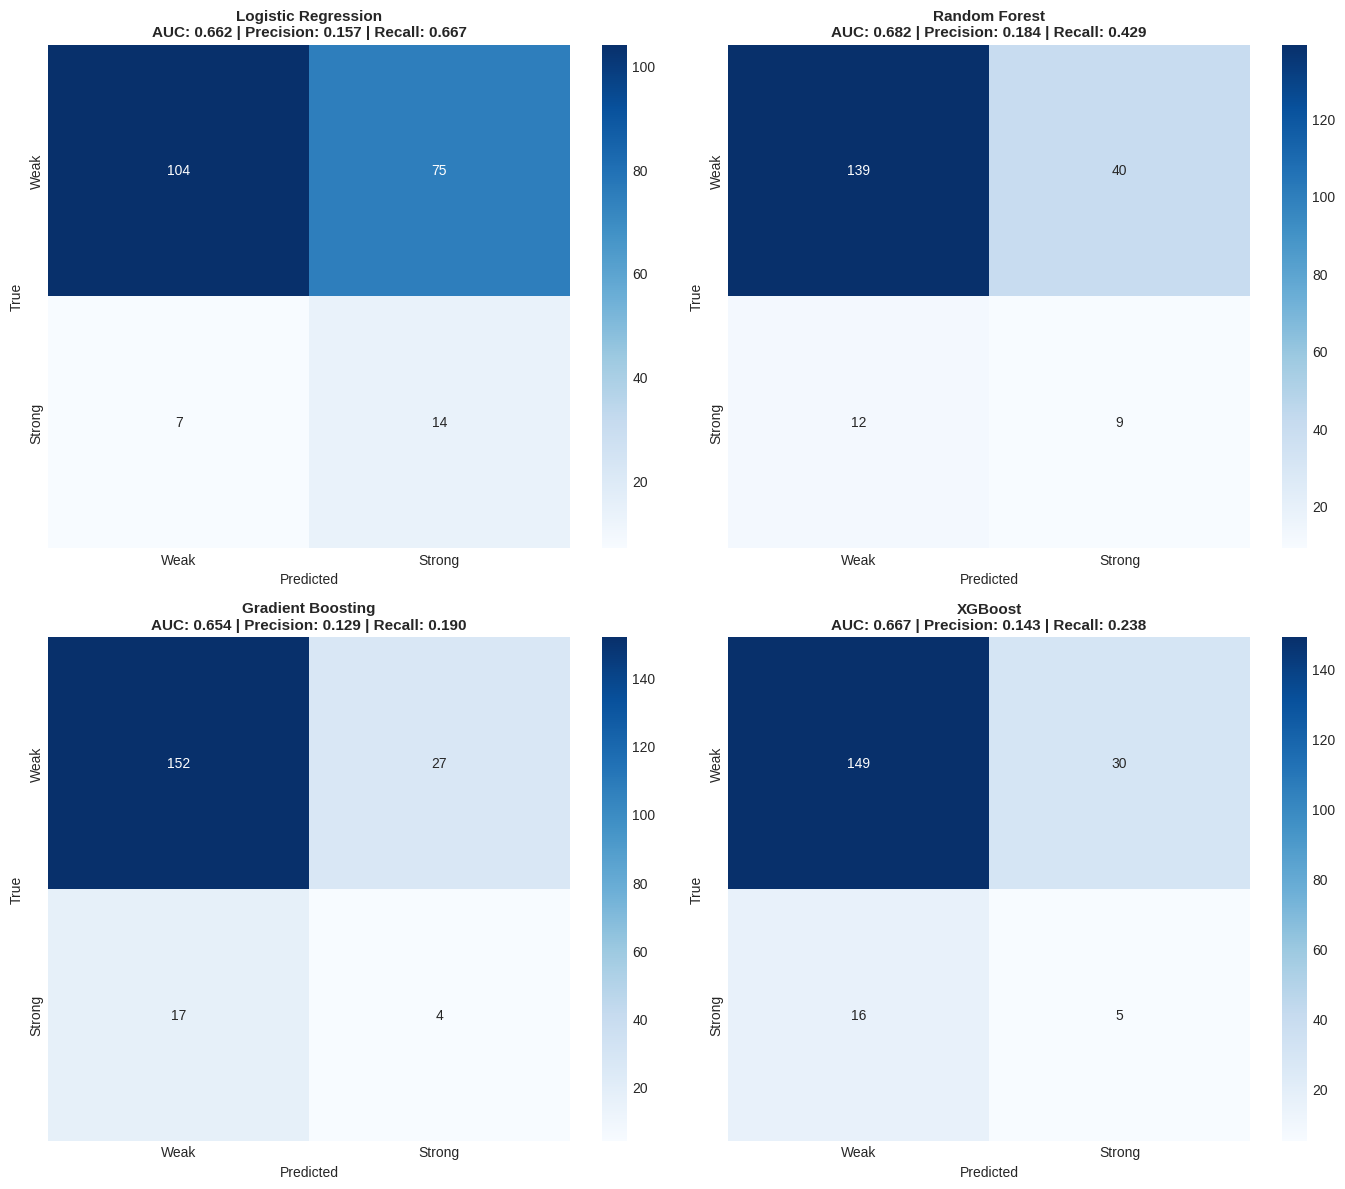


--------------------------------------------------------------------------------
FEATURE IMPORTANCE:
--------------------------------------------------------------------------------

Random Forest - Top 5 Features:
         feature  importance
     shear_0_1km    0.183258
     dewpoint_2m    0.133050
surface_pressure    0.129518
         temp_2m    0.128202
            cape    0.116043

Gradient Boosting - Top 5 Features:
         feature  importance
     shear_0_1km    0.175747
     dewpoint_2m    0.140780
     shear_0_3km    0.124266
surface_pressure    0.122531
             cin    0.119594

XGBoost - Top 5 Features:
         feature  importance
             cin    0.141364
     shear_0_1km    0.127468
            cape    0.126193
         temp_2m    0.124777
surface_pressure    0.123778


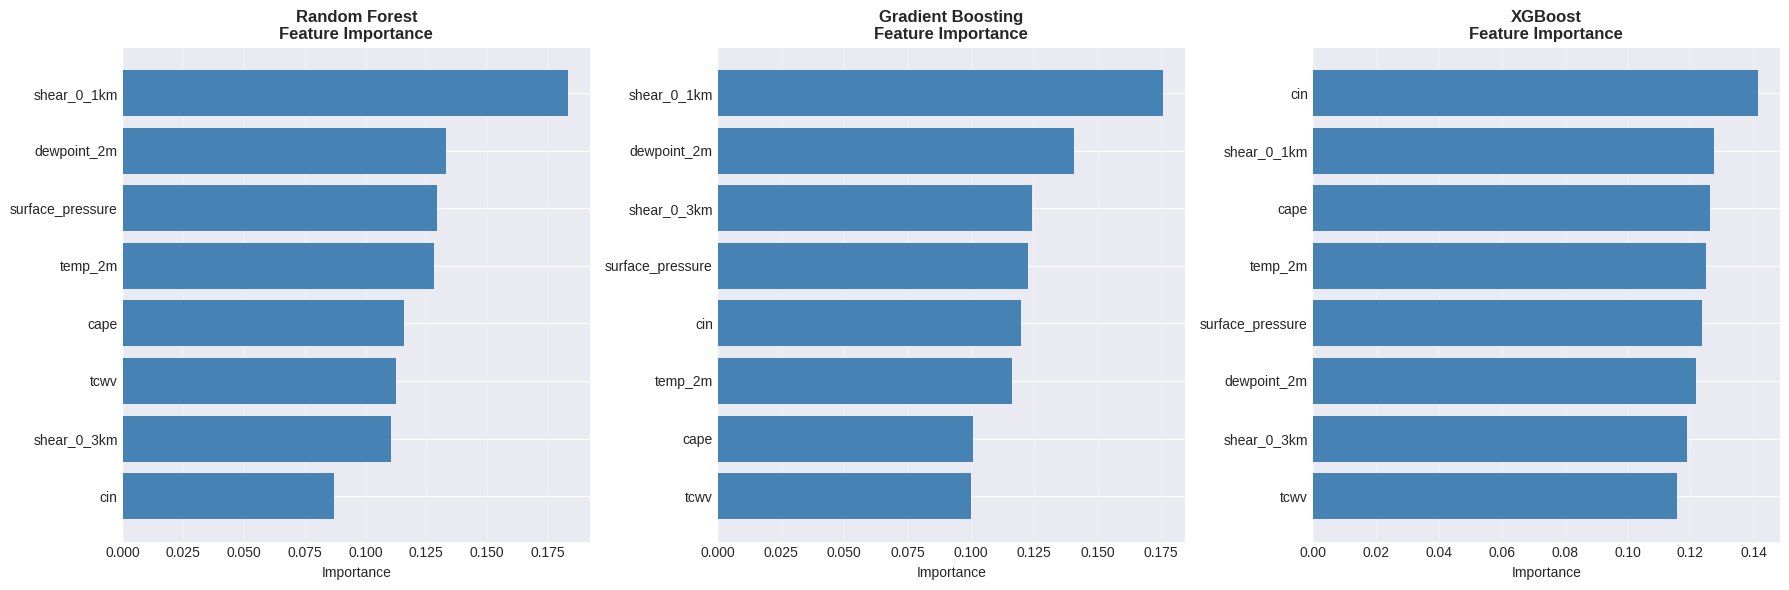


STEP 6B: MULTI-CLASS CLASSIFICATION - ADVANCED CHALLENGE

Applying SMOTE for multi-class classification...
✓ Training samples: 640 → 1328
  Class 0: 332
  Class 1: 332
  Class 2: 332
  Class 3: 332

--------------------------------------------------------------------------------
TRAINING MULTI-CLASS CLASSIFICATION MODELS:
--------------------------------------------------------------------------------

Training: Logistic Regression
  CV Accuracy: 0.3878 (±0.0476)
  Test Accuracy: 0.3600

Training: Random Forest
  CV Accuracy: 0.6883 (±0.0289)
  Test Accuracy: 0.4700

Training: Gradient Boosting
  CV Accuracy: 0.7199 (±0.0355)
  Test Accuracy: 0.5050

Training: XGBoost
  CV Accuracy: 0.7176 (±0.0301)
  Test Accuracy: 0.5000

STEP 7B: MULTI-CLASS CLASSIFICATION EVALUATION

MODEL COMPARISON:
                      cv_mean test_accuracy
Logistic Regression  0.387814          0.36
Random Forest        0.688254          0.47
Gradient Boosting    0.719901         0.505
XGBoost              0.

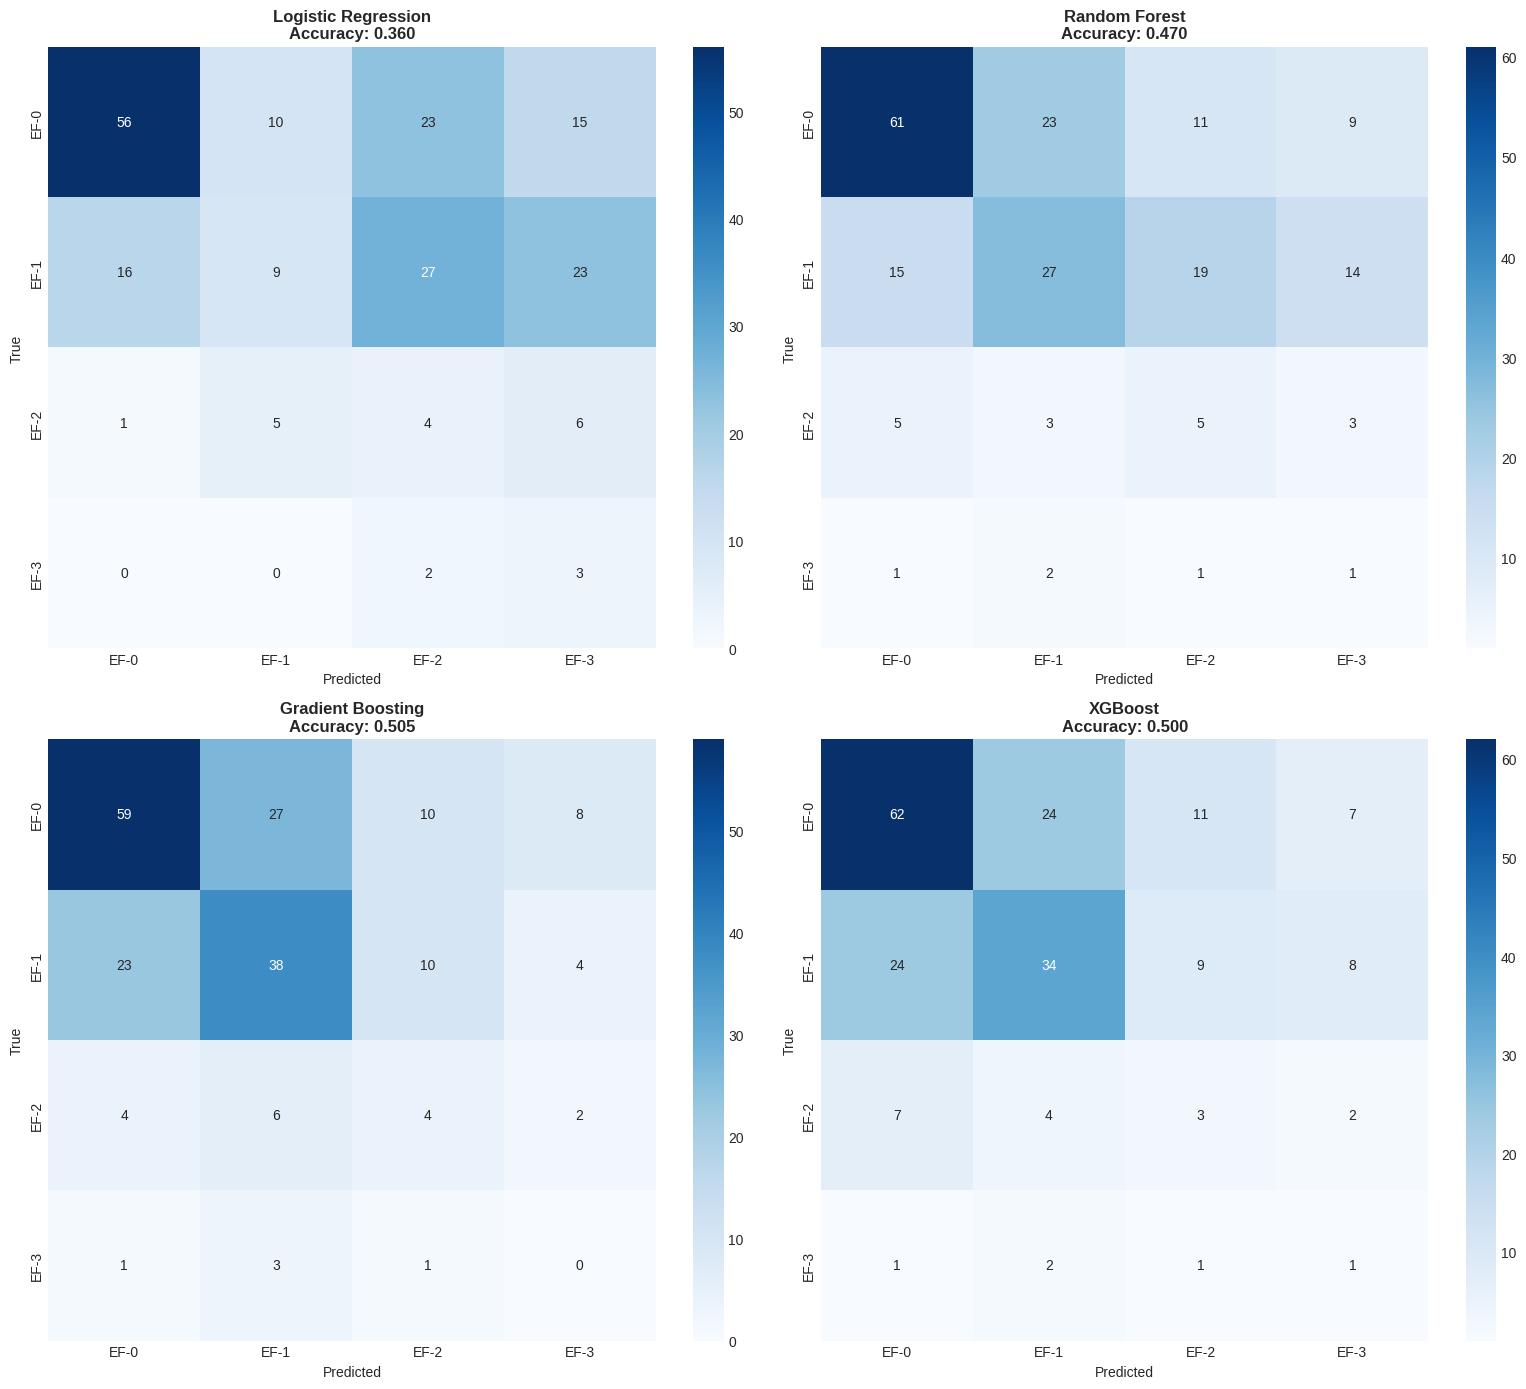


STEP 8: FINAL SUMMARY & QUANTUM CHALLENGE TARGETS

✅ CLASSICAL BASELINE ANALYSIS COMPLETE!

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DATASET SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Training Samples: 640
• Test Samples: 200
• Features: 8 meteorological variables
• Targets: Binary (ef_binary) + Multi-class (ef_class)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 YOUR QUANTUM CHALLENGE TARGETS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

PRIMARY CHALLENGE (Binary Classification):
Best Model: Random Forest
Target ROC AUC to Beat: 0.6824

ADVANCED CHALLENGE (Multi-class Classification):
Best Model: Gradient Boosting
Target Accuracy to Beat: 0.5050

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DATA AVAILABLE FOR QUANTUM MODELS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Binary Classification:
- X_train_balanced_binary: (1142, 8)
- y_trai

In [ ]:
# ============================================================================
# STEP 6A: BINARY CLASSIFICATION (PRIMARY CHALLENGE)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6A: BINARY CLASSIFICATION - PRIMARY CHALLENGE")
print("=" * 80)

# Apply SMOTE for binary classification
print("\nApplying SMOTE for binary classification...")
smote_binary = SMOTE(random_state=42)
X_train_balanced_binary, y_train_balanced_binary = smote_binary.fit_resample(
    X_train_scaled, y_train_binary
)
print(f"✓ Training samples: {len(y_train_binary)} → {len(y_train_balanced_binary)}")
print(f"  Class 0: {(y_train_balanced_binary == 0).sum()}")
print(f"  Class 1: {(y_train_balanced_binary == 1).sum()}")

# Define models
models_binary = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced', solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4,
        random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        min_samples_split=10, min_samples_leaf=4, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42,
        eval_metric='logloss', use_label_encoder=False
    )
}

results_binary = {}
trained_models_binary = {}

print("\n" + "-" * 80)
print("TRAINING BINARY CLASSIFICATION MODELS:")
print("-" * 80)

for name, model in models_binary.items():
    print(f"\nTraining: {name}")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_balanced_binary, y_train_balanced_binary,
                                cv=cv, scoring='roc_auc', n_jobs=-1)

    # Train model
    model.fit(X_train_balanced_binar0.183258
     dewpoint_2m    0.133050y, y_train_balanced_binary)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Probabilities
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train_scaled)
        y_test_proba = model.decision_function(X_test_scaled)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train_binary, y_train_pred)
    test_accuracy = accuracy_score(y_test_binary, y_test_pred)
    train_roc_auc = roc_auc_score(y_train_binary, y_train_proba)
    test_roc_auc = roc_auc_score(y_test_binary, y_test_proba)

    results_binary[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba
    }

    trained_models_binary[name] = model

    print(f"  CV ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Test ROC AUC: {test_roc_auc:.4f} | Accuracy: {test_accuracy:.4f}")

# ============================================================================
# STEP 7A: BINARY CLASSIFICATION EVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7A: BINARY CLASSIFICATION EVALUATION")
print("=" * 80)

results_df_binary = pd.DataFrame(results_binary).T
print("\nMODEL COMPARISON:")
print(results_df_binary[['cv_mean', 'test_roc_auc', 'test_accuracy']].round(4))

best_model_name_binary = results_df_binary['test_roc_auc'].idxmax()
best_roc_auc_binary = results_df_binary.loc[best_model_name_binary, 'test_roc_auc']

print(f"\n🏆 BEST MODEL: {best_model_name_binary}")
print(f"   ROC AUC: {best_roc_auc_binary:.4f}")

# Classification report
print("\n" + "-" * 80)
print(f"CLASSIFICATION REPORT - {best_model_name_binary}:")
print("-" * 80)
y_pred_best = results_binary[best_model_name_binary]['y_pred']
print(classification_report(y_test_binary, y_pred_best,
                          target_names=['Weak (EF0-1)', 'Strong (EF2+)'], digits=4))

# ROC Curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results_binary.items()):
    fpr, tpr, _ = roc_curve(y_test_binary, result['y_proba'])
    roc_auc = result['test_roc_auc']

    axes[idx].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    axes[idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate', fontsize=11)
    axes[idx].set_ylabel('True Positive Rate', fontsize=11)
    axes[idx].set_title(f'{name}\nROC Curve', fontsize=13, fontweight='bold')
    axes[idx].legend(loc="lower right")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results_binary.items()):
    cm = confusion_matrix(y_test_binary, result['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Weak', 'Strong'], yticklabels=['Weak', 'Strong'])

    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    axes[idx].set_title(f'{name}\nAUC: {result["test_roc_auc"]:.3f} | ' +
                       f'Precision: {precision:.3f} | Recall: {recall:.3f}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.show()

# Feature Importance
importance_data = {}
for name, model in trained_models_binary.items():
    if hasattr(model, 'feature_importances_'):
        importance_data[name] = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

if importance_data:
    print("\n" + "-" * 80)
    print("FEATURE IMPORTANCE:")
    print("-" * 80)

    fig, axes = plt.subplots(1, min(len(importance_data), 3), figsize=(18, 6))
    if len(importance_data) == 1:
        axes = [axes]

    for idx, (name, imp_df) in enumerate(list(importance_data.items())[:3]):
        print(f"\n{name} - Top 5 Features:")
        print(imp_df.head(5).to_string(index=False))

        axes[idx].barh(imp_df['feature'], imp_df['importance'], color='steelblue')
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name}\nFeature Importance', fontsize=12, fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================================================
# STEP 6B: MULTI-CLASS CLASSIFICATION (ADVANCED CHALLENGE)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6B: MULTI-CLASS CLASSIFICATION - ADVANCED CHALLENGE")
print("=" * 80)

# Apply SMOTE for multi-class
print("\nApplying SMOTE for multi-class classification...")
smote_class = SMOTE(random_state=42)
X_train_balanced_class, y_train_balanced_class = smote_class.fit_resample(
    X_train_scaled, y_train_class
)
print(f"✓ Training samples: {len(y_train_class)} → {len(y_train_balanced_class)}")
for cls in sorted(pd.Series(y_train_balanced_class).unique()):
    print(f"  Class {cls}: {(y_train_balanced_class == cls).sum()}")

# Define models
models_class = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced',
        multi_class='multinomial', solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4,
        random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        min_samples_split=10, min_samples_leaf=4, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42,
        eval_metric='mlogloss', use_label_encoder=False
    )
}

results_class = {}
trained_models_class = {}

print("\n" + "-" * 80)
print("TRAINING MULTI-CLASS CLASSIFICATION MODELS:")
print("-" * 80)

for name, model in models_class.items():
    print(f"\nTraining: {name}")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_balanced_class, y_train_balanced_class,
                                cv=cv, scoring='accuracy', n_jobs=-1)

    # Train model
    model.fit(X_train_balanced_class, y_train_balanced_class)

    # Predictions
    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_class, y_test_pred)

    results_class[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'y_pred': y_test_pred
    }

    trained_models_class[name] = model

    print(f"  CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

# ============================================================================
# STEP 7B: MULTI-CLASS CLASSIFICATION EVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7B: MULTI-CLASS CLASSIFICATION EVALUATION")
print("=" * 80)

results_df_class = pd.DataFrame(results_class).T
print("\nMODEL COMPARISON:")
print(results_df_class[['cv_mean', 'test_accuracy']].round(4))

best_model_name_class = results_df_class['test_accuracy'].idxmax()
best_accuracy_class = results_df_class.loc[best_model_name_class, 'test_accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name_class}")
print(f"   Accuracy: {best_accuracy_class:.4f}")

# Classification report
print("\n" + "-" * 80)
print(f"CLASSIFICATION REPORT - {best_model_name_class}:")
print("-" * 80)
y_pred_best_class = results_class[best_model_name_class]['y_pred']
print(classification_report(y_test_class, y_pred_best_class,
                          target_names=[f'EF-{i}' for i in range(4)], digits=4))

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (name, result) in enumerate(results_class.items()):
    cm = confusion_matrix(y_test_class, result['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=[f'EF-{i}' for i in range(4)],
                yticklabels=[f'EF-{i}' for i in range(4)])

    axes[idx].set_title(f'{name}\nAccuracy: {result["test_accuracy"]:.3f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 8: FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("STEP 8: FINAL SUMMARY & QUANTUM CHALLENGE TARGETS")
print("=" * 80)

print(f"""
✅ CLASSICAL BASELINE ANALYSIS COMPLETE!

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DATASET SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Training Samples: {X_train.shape[0]}
• Test Samples: {X_test.shape[0]}
• Features: {X_train.shape[1]} meteorological variables
• Targets: Binary (ef_binary) + Multi-class (ef_class)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 YOUR QUANTUM CHALLENGE TARGETS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

PRIMARY CHALLENGE (Binary Classification):
Best Model: {best_model_name_binary}
Target ROC AUC to Beat: {best_roc_auc_binary:.4f}

ADVANCED CHALLENGE (Multi-class Classification):
Best Model: {best_model_name_class}
Target Accuracy to Beat: {best_accuracy_class:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DATA AVAILABLE FOR QUANTUM MODELS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Binary Classification:
- X_train_balanced_binary: {X_train_balanced_binary.shape}
- y_train_balanced_binary: {y_train_balanced_binary.shape}
- X_test_scaled: {X_test_scaled.shape}
- y_test_binary: {y_test_binary.shape}

Multi-class Classification:
- X_train_balanced_class: {X_train_balanced_class.shape}
- y_train_balanced_class: {y_train_balanced_class.shape}
- X_test_scaled: {X_test_scaled.shape}
- y_test_class: {y_test_class.shape}
